In [63]:
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import numpy as np

from pmdarima.arima import auto_arima
import statsmodels.api as sm

In [41]:
df = pd.read_csv('/home/ai003/Desktop/t/2/4107/AIR.PA.csv')

In [42]:
df.Date.min(), df.Date.max()

('2002-04-01', '2023-03-01')

In [43]:
df.Date = pd.to_datetime(df.Date, errors='coerce')

In [5]:
df['average'] = (df.High + df.Low) / 2

<AxesSubplot:ylabel='Density'>

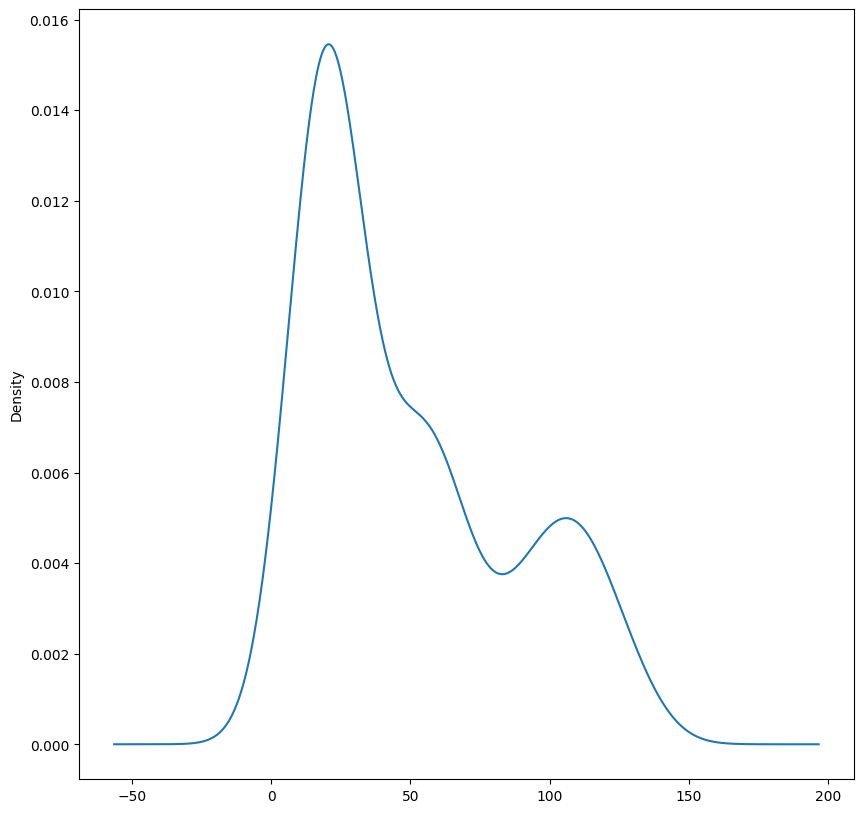

In [46]:
#Distribution of the dataset
df_close = df['Close']
df_close.plot(kind='kde')

A time series is also regarded to include three systematic components: level, trend, and seasonality, as well as one non-systematic component termed noise.

The following are the components’ definitions:
The average value in the series is called the level.
The increasing or falling value in the series is referred to as the trend.
Seasonality is the series’ recurring short-term cycle.
The random variance in the series is referred to as noise.
Because time series analysis only works with stationary data, we must first determine whether a series is stationary.

ADF (Augmented Dickey-Fuller) Test
One of the most widely used statistical tests is the Dickey-Fuller test. It can be used to determine whether or not a series has a unit root, and thus whether or not the series is stationary. This test’s null and alternate hypotheses are:

Null Hypothesis: The series has a unit root (value of a =1)

Alternate Hypothesis: The series has no unit root.

If the null hypothesis is not rejected, the series is said to be non-stationary. The series can be linear or difference stationary as a result of this.

The series becomes stationary if both the mean and standard deviation are flat lines (constant mean and constant variance).

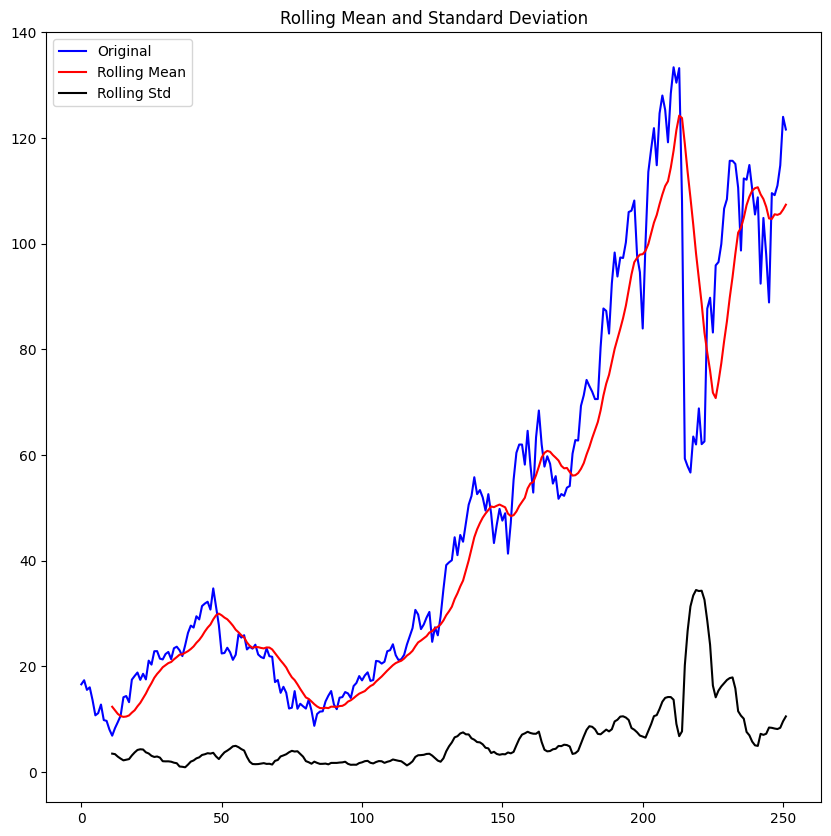

Results of dickey fuller test
Test Statistics                  0.051895
p-value                          0.962619
No. of lags used                13.000000
Number of observations used    238.000000
critical value (1%)             -3.458128
critical value (5%)             -2.873762
critical value (10%)            -2.573283
dtype: float64


In [48]:
from statsmodels.tsa.stattools import adfuller

#Test for staionarity
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
test_stationarity(df_close)

<Figure size 1000x1000 with 0 Axes>

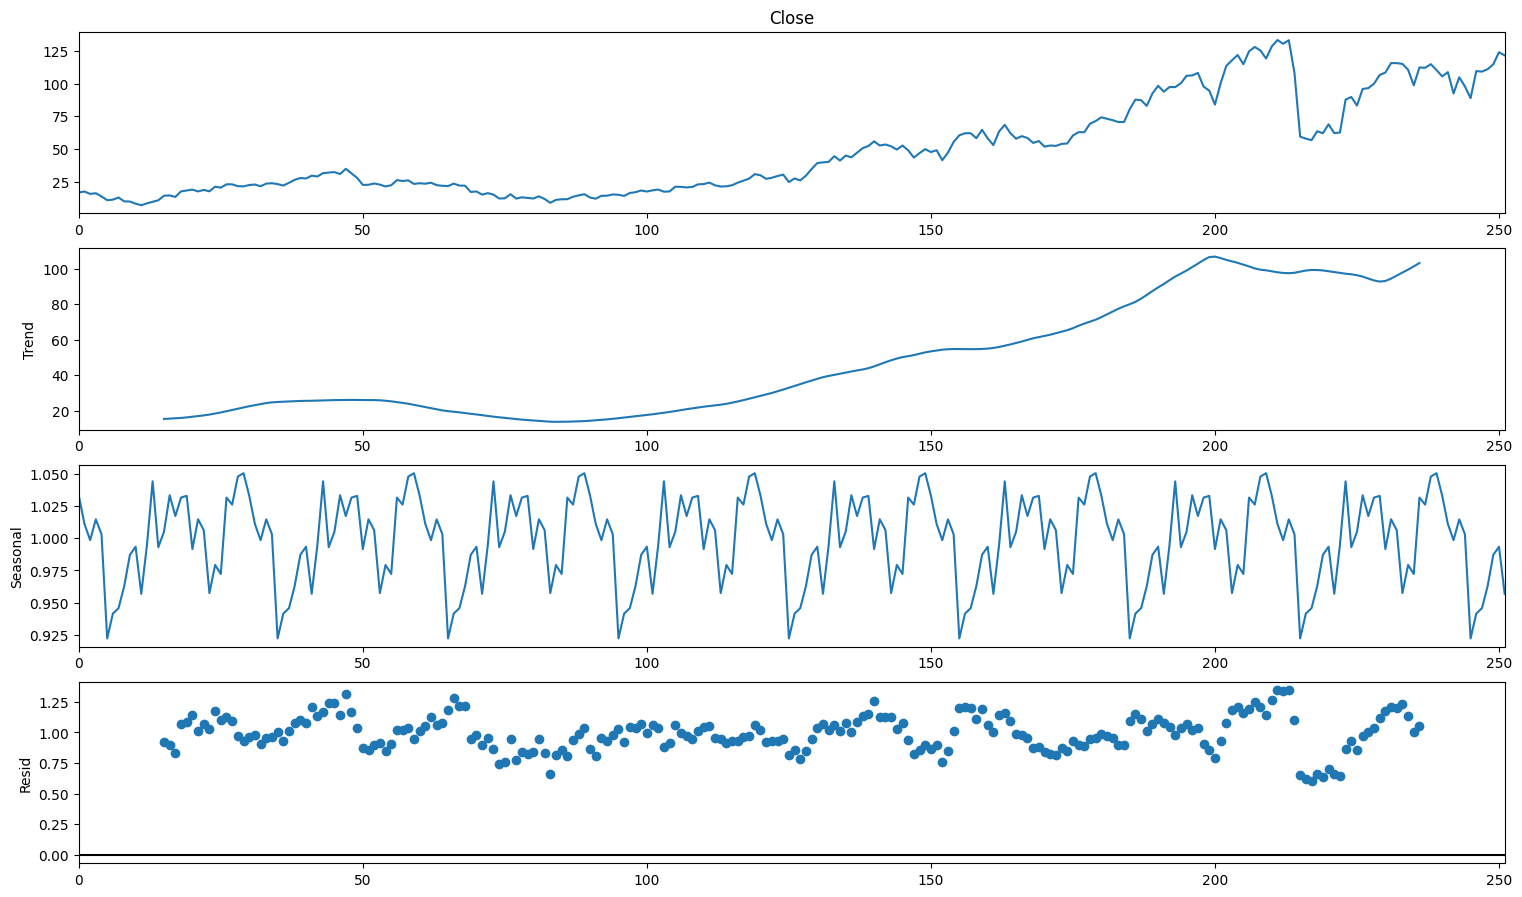

In [51]:
#To separate the trend and the seasonality from a time series, 
# we can decompose the series using the following code.
result = seasonal_decompose(df_close, model='multiplicative', period = 30)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)

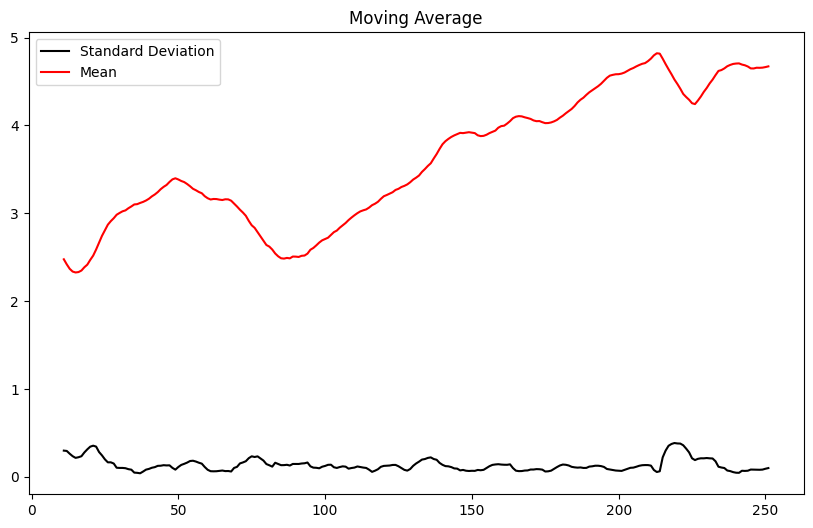

In [55]:
#if not stationary then eliminate trend
#Eliminate trend
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
df_log = np.log(df_close)
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

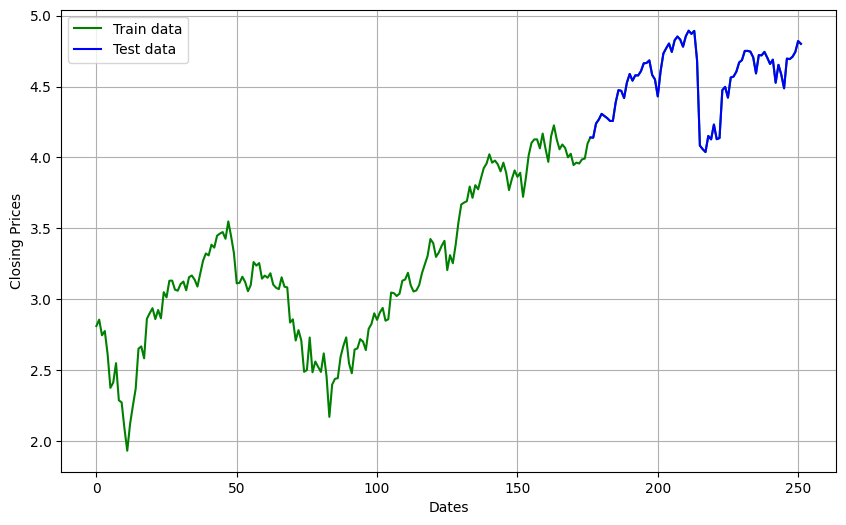

In [104]:
#split data into train and training set
train_data, test_data = df_log[3:int(len(df_log)*0.7)], df_log[int(len(df_log)*0.7):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-290.626, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-289.051, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-289.117, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-291.664, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-287.290, Time=0.14 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.242 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  173
Model:               SARIMAX(0, 1, 0)   Log Likelihood                 146.832
Date:                Tue, 14 Mar 2023   AIC                           -291.664
Time:                        18:40:30   BIC                           -288.517
Sample:                             0   HQIC                          -290.387
                                - 173                                       

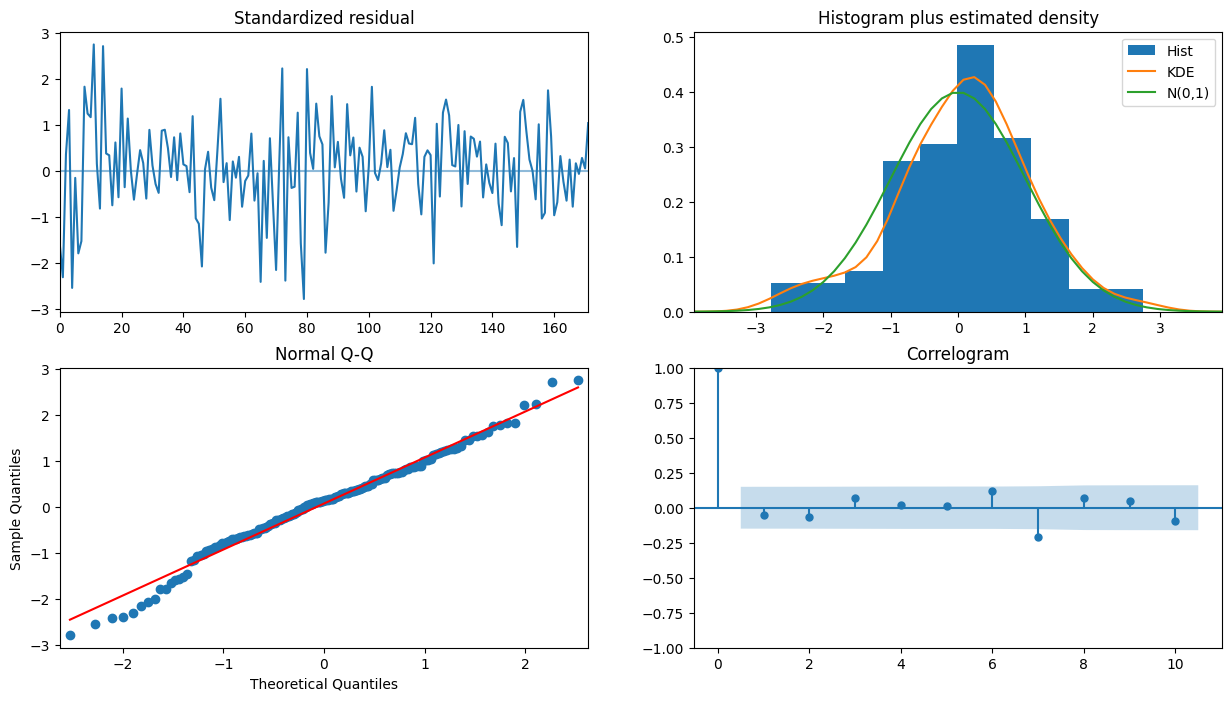

In [105]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [147]:
def comb(L):
    comb = []
    for i in range(3):
        for j in range(3):
            for k in range(3):
                  
                # check if the indexes are not
                # same
                if (i!=j and j!=k and i!=k):
                     comb.append([L[i], L[j], L[k]])
    return comb
# Driver Code

(0, 1, 0)
(0, 0, 1)
(1, 0, 0)
(1, 0, 0)
(0, 0, 1)
(0, 1, 0)


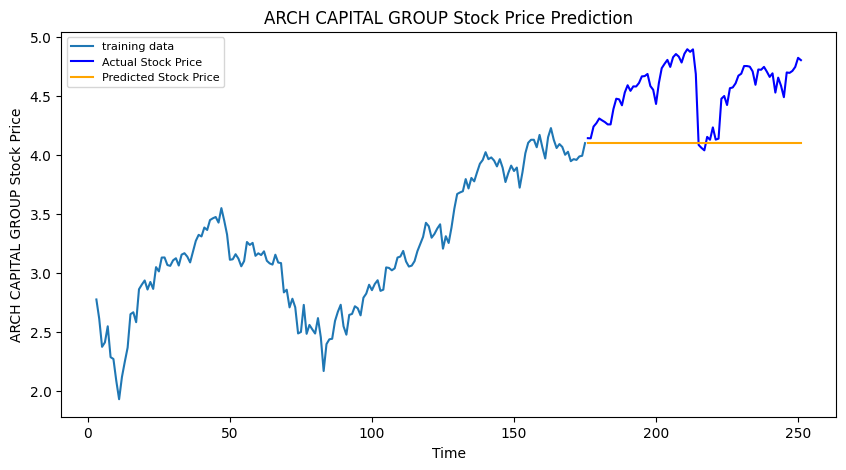

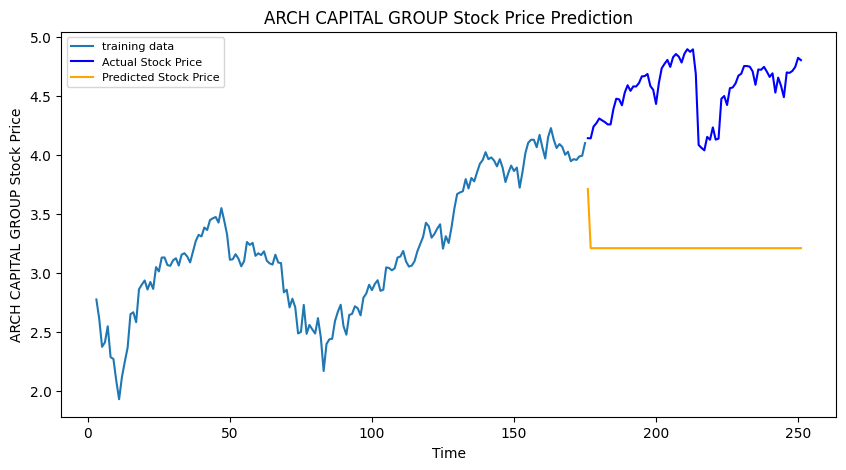

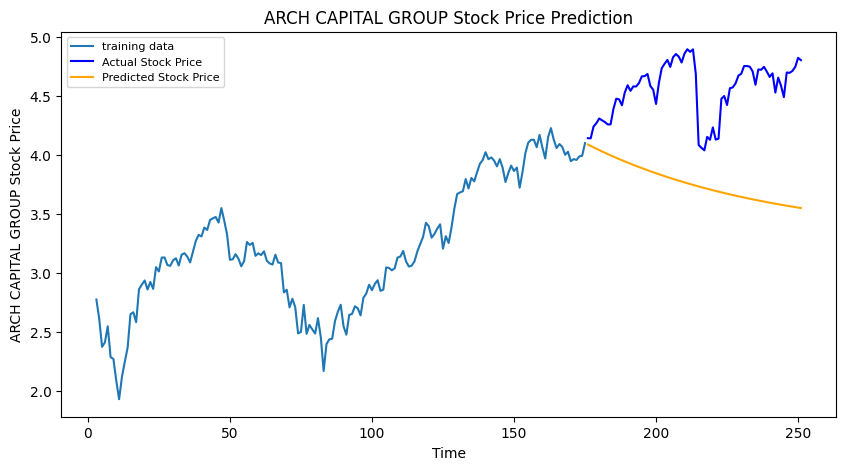

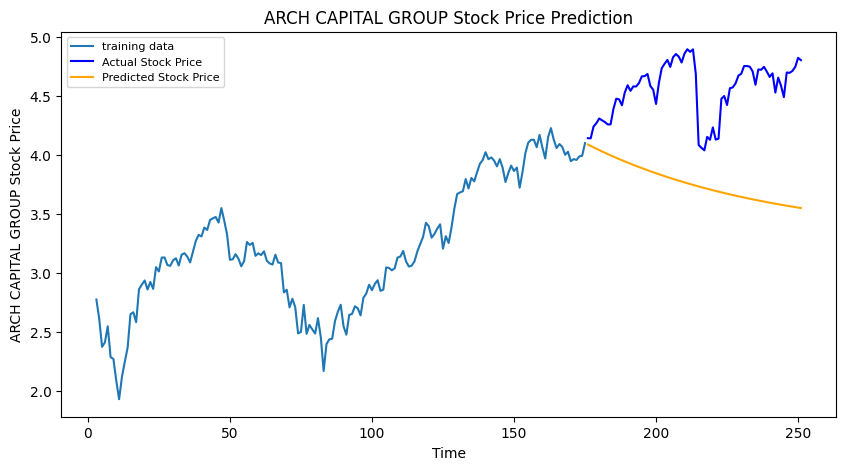

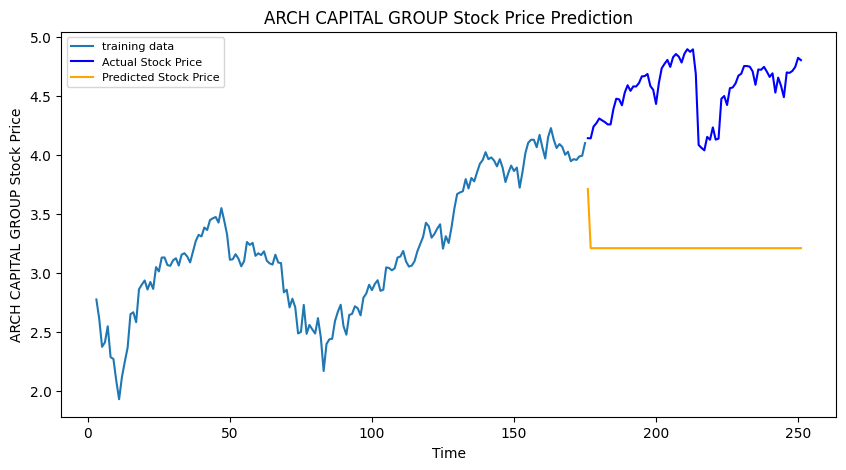

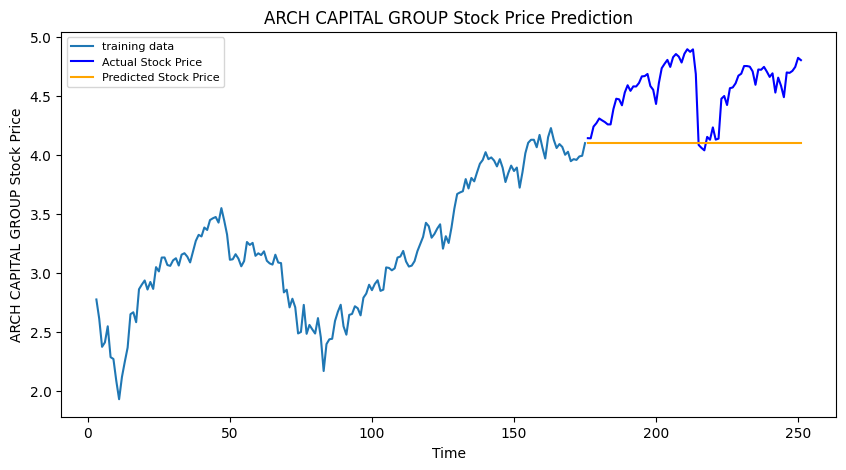

In [148]:
# Modeling
# Build Model
for i in comb([0,1,0]):
    a = (i[0],i[1],i[2])
    model = sm.tsa.arima.ARIMA(train_data, order=a)
    fitted = model.fit()  
    #print(fitted.summary())

    # Forecast
    #fc, conf = fitted.forecast(321, alpha=0.05)  # 95% conf
    # Make as pandas series
    #fc_series = pd.Series(fc, index=test_data.index)
    #lower_series = pd.Series(conf[:, 0], index=test_data.index)
    #upper_series = pd.Series(conf[:, 1], index=test_data.index)

    a = fitted.forecast(76, alpha=0.05)

    fc_series = pd.Series(a.values, index=test_data.index)

    # Plot
    plt.figure(figsize=(10,5), dpi=100)
    plt.plot(train_data, label='training data')
    plt.plot(test_data, color = 'blue', label='Actual Stock Price')
    plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')
    #plt.fill_between(lower_series.index, lower_series, upper_series, 
    #                 color='k', alpha=.10)
    plt.title('ARCH CAPITAL GROUP Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('ARCH CAPITAL GROUP Stock Price')
    plt.legend(loc='upper left', fontsize=8)
    plt.show()

In [149]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

# report performance
mse = mean_squared_error(test_data, a)
print('MSE: '+str(mse))
mae = mean_absolute_error(test_data, a)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test_data, a))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(a - test_data)/np.abs(test_data))
print('MAPE: '+str(mape))

MSE: 0.25948710454786006
MAE: 0.4569257466302508
RMSE: 0.5093987677133309
MAPE: 0.09802991741915065


In [6]:
df[['Date', 'average', 'Volume']]

,Date,average,Volume
0,2002-04-01,16.130000,38651590
1,2002-05-01,17.190001,40982303
2,2002-06-01,15.815000,33304420
3,2002-07-01,15.494999,49763299
4,2002-08-01,15.070000,37693937
...,...,...,...
247,2022-11-01,111.440002,31325486
248,2022-12-01,110.670002,20966257
249,2023-01-01,116.849998,25772093
250,2023-02-01,119.010002,28092969


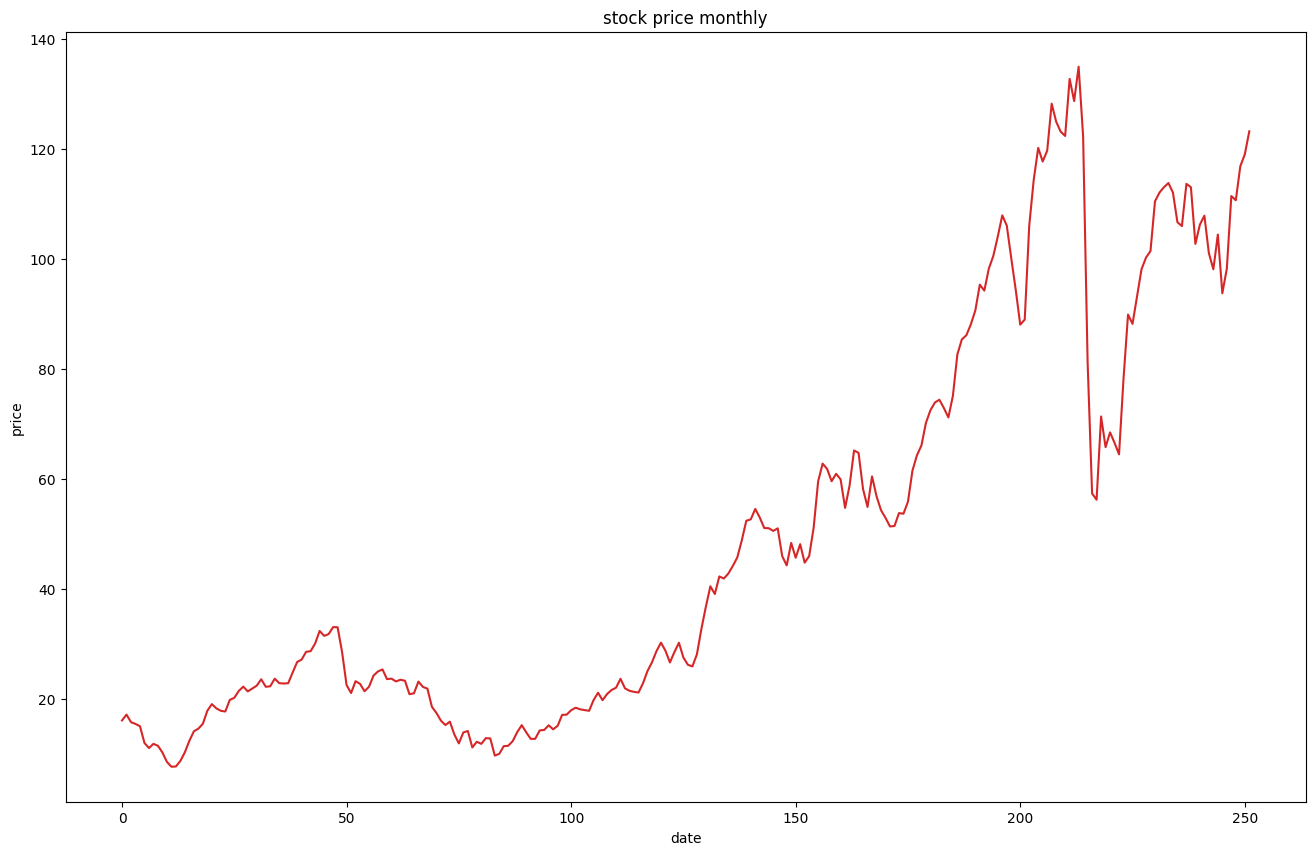

In [7]:
plt.figure(figsize=(16,10), dpi=100)
plt.plot(df.index, df.average, color='tab:red')
plt.gca().set(title='stock price monthly', xlabel='date', ylabel='price')
plt.show()

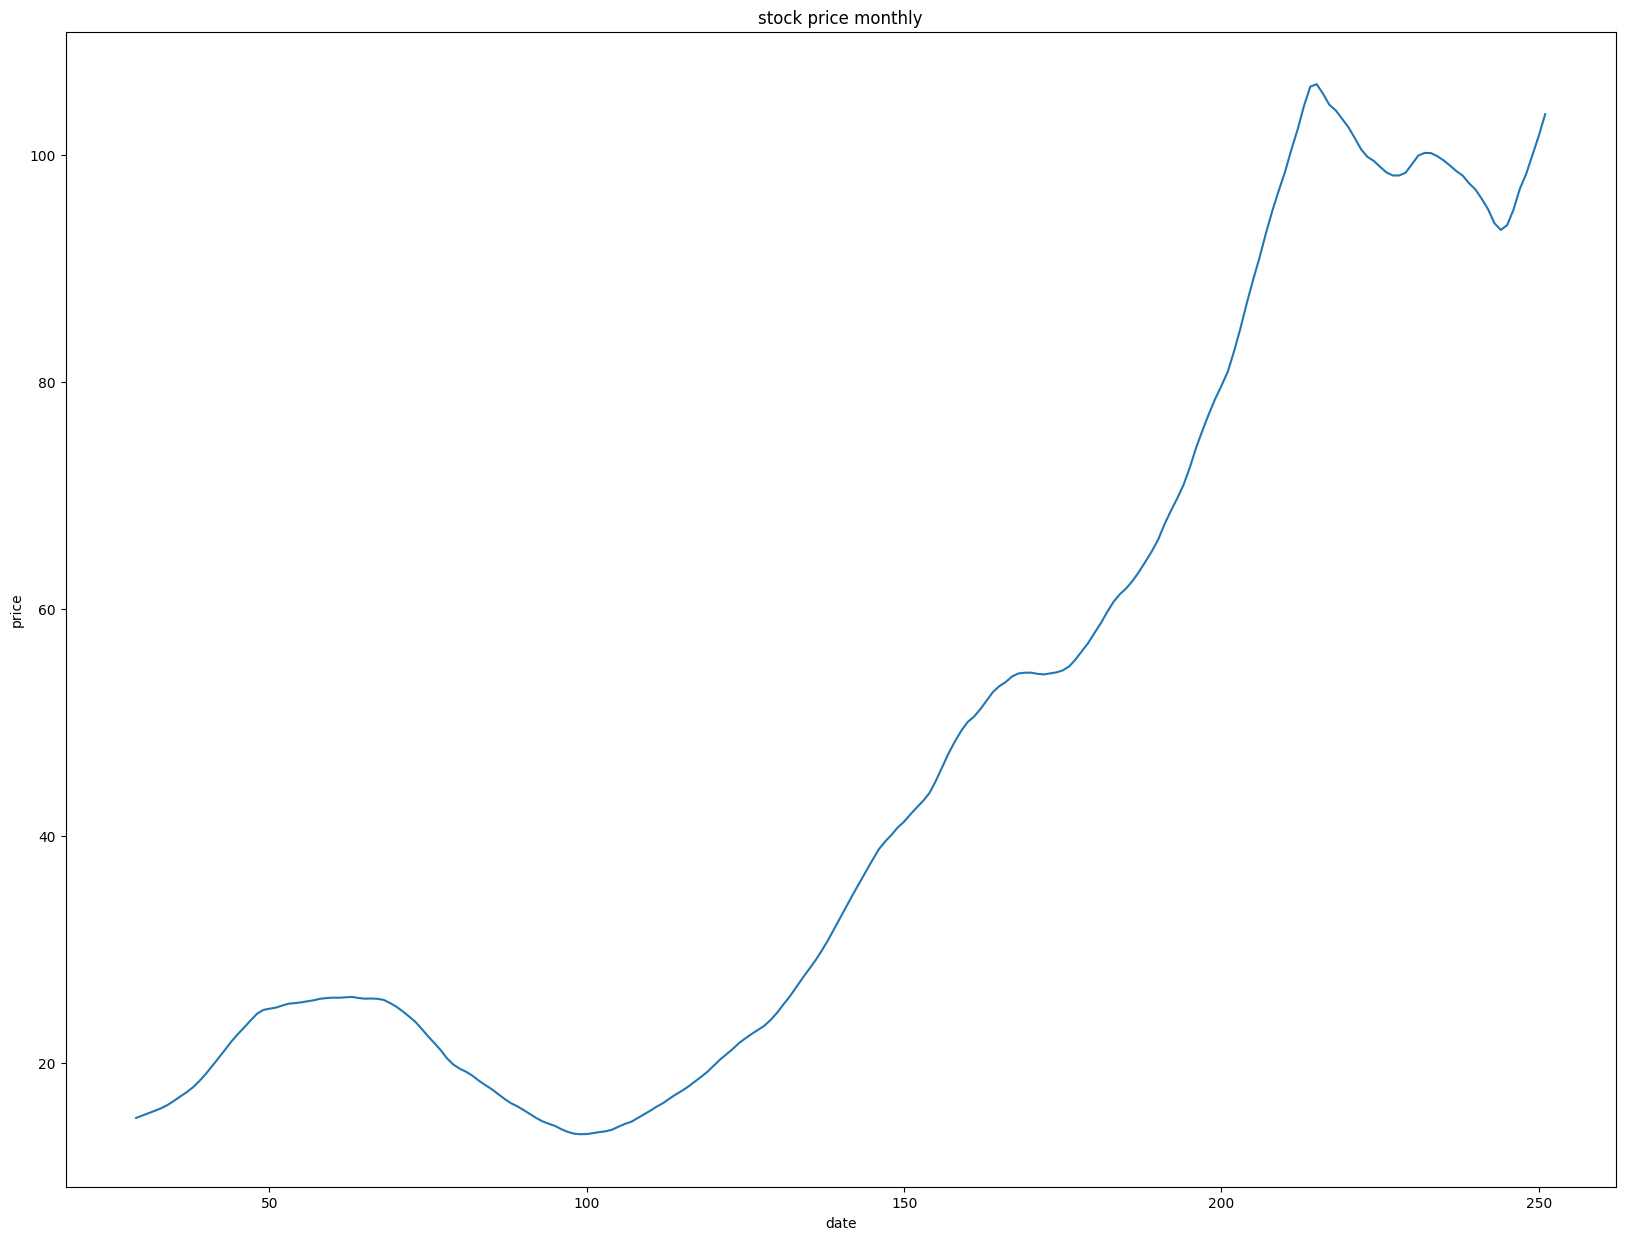

In [8]:
temp_mean_df = df.average.rolling(window=30).mean() ###moving average smoothing
temp_mean_df.plot(figsize=(20,15))
plt.gca().set(title='stock price monthly', xlabel='date', ylabel='price')
plt.show()

In [10]:
df.average

0       16.130000
1       17.190001
2       15.815000
3       15.494999
4       15.070000
          ...    
247    111.440002
248    110.670002
249    116.849998
250    119.010002
251    123.200001
Name: average, Length: 252, dtype: float64

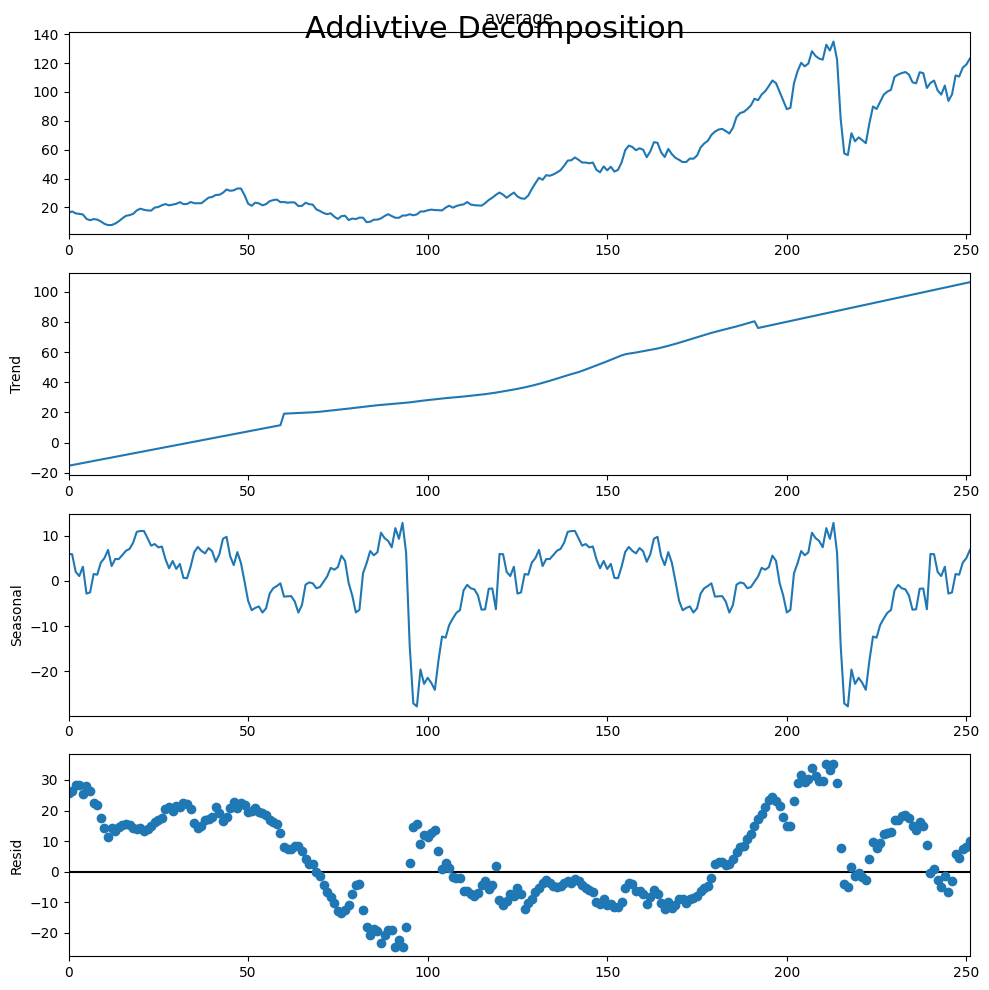

In [17]:
from statsmodels.tsa.seasonal import seasonal_decompose
result_add = seasonal_decompose(df.average, model='addictive', extrapolate_trend='freq', period=120)

plt.rcParams.update({'figure.figsize':(10,10)})
result_add.plot().suptitle('Addivtive Decomposition', fontsize=22)
plt.show()

In [31]:
predicted_df = df.set_index('Date').average.to_frame().shift(1).rename(columns = {'average':'average_pred'})
actual_df = df.set_index('Date').average.to_frame().rename(columns = {'average':'average_actual'})

one_step_df = pd.concat([actual_df,predicted_df],axis = 1)
one_step_df = one_step_df[1:]
print(one_step_df.head(10))

from sklearn.metrics import mean_squared_error as MSE
from math import sqrt

temp_pred_err = sqrt(MSE(one_step_df.average_actual, one_step_df.average_pred)) 
print('The RMSE is', temp_pred_err)

            average_actual  average_pred
Date                                    
2002-05-01       17.190001     16.130000
2002-06-01       15.815000     17.190001
2002-07-01       15.494999     15.815000
2002-08-01       15.070000     15.494999
2002-09-01       12.030000     15.070000
2002-10-01       11.110000     12.030000
2002-11-01       11.870000     11.110000
2002-12-01       11.520000     11.870000
2003-01-01       10.295000     11.520000
2003-02-01        8.590000     10.295000
The RMSE is 4.7293103532947995


In [32]:
import itertools 
p = d = q = range(0,2)
pdq = list(itertools.product(p,d,q))
seasonal_pdq = [(x[0],x[1],x[2],12) for x in list(itertools.product(p,d,q))]

/home/ai003/anaconda3/envs/ML4016/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/ai003/anaconda3/envs/ML4016/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.75581D+00    |proj g|=  6.96989D-02

At iterate    5    f=  2.67035D+00    |proj g|=  9.12952D-02

At iterate   10    f=  2.65552D+00    |proj g|=  1.27849D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     14     17      1     0     0   2.565D-06   2.656D+00
  F =   2.6555040336184383     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


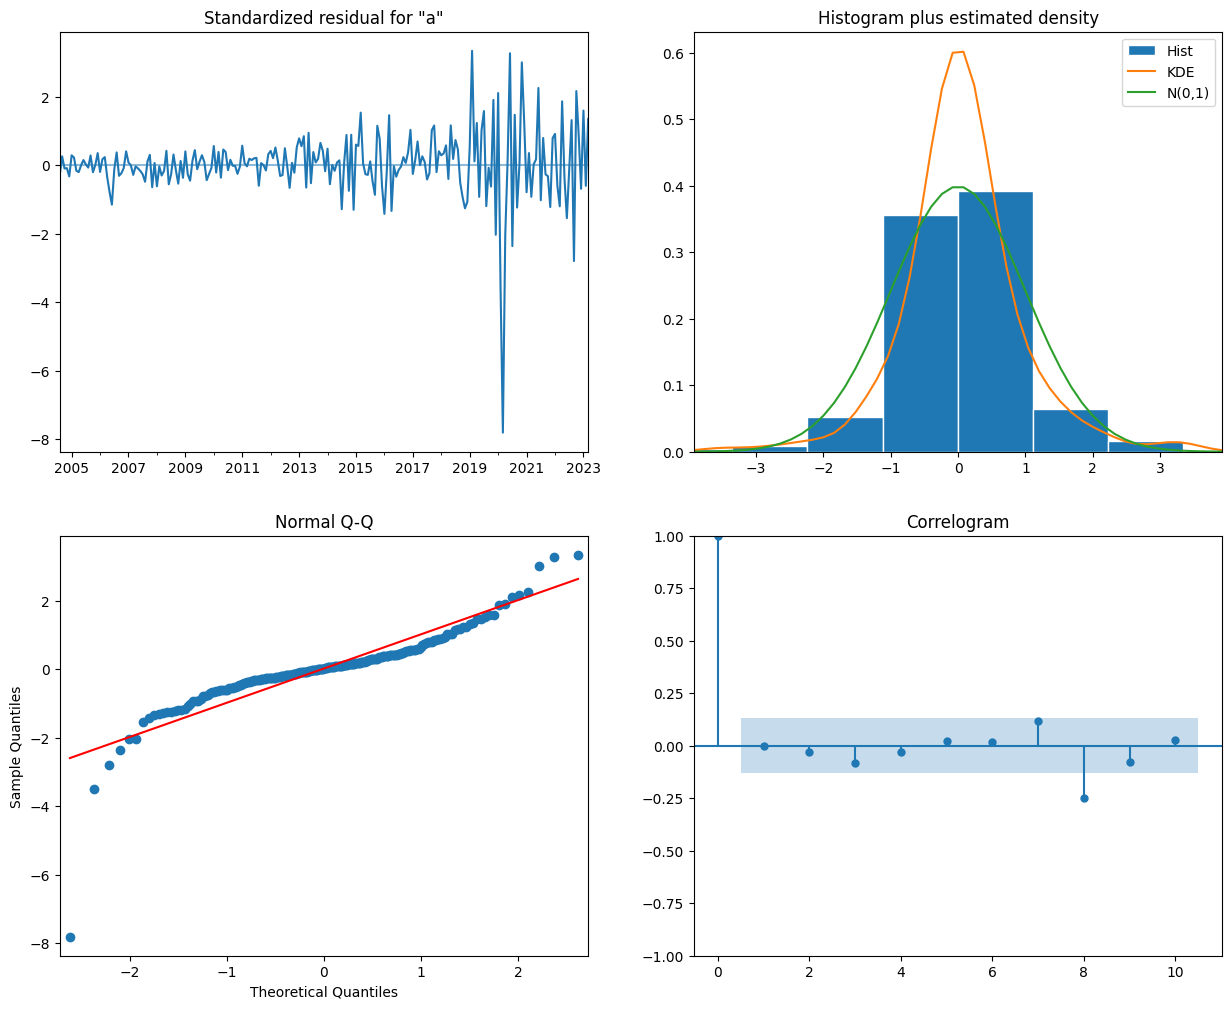

In [33]:
import statsmodels.api as sm
mod = sm.tsa.statespace.SARIMAX(one_step_df.average_actual,
                               order=(1,1,1),
                               seasonal_order=(1,1,1,12),
                               enforce_stationarity=False,
                               enforce_invertibility=False)
results = mod.fit()
results.plot_diagnostics(figsize=(15,12))
plt.savefig('6')
plt.show()

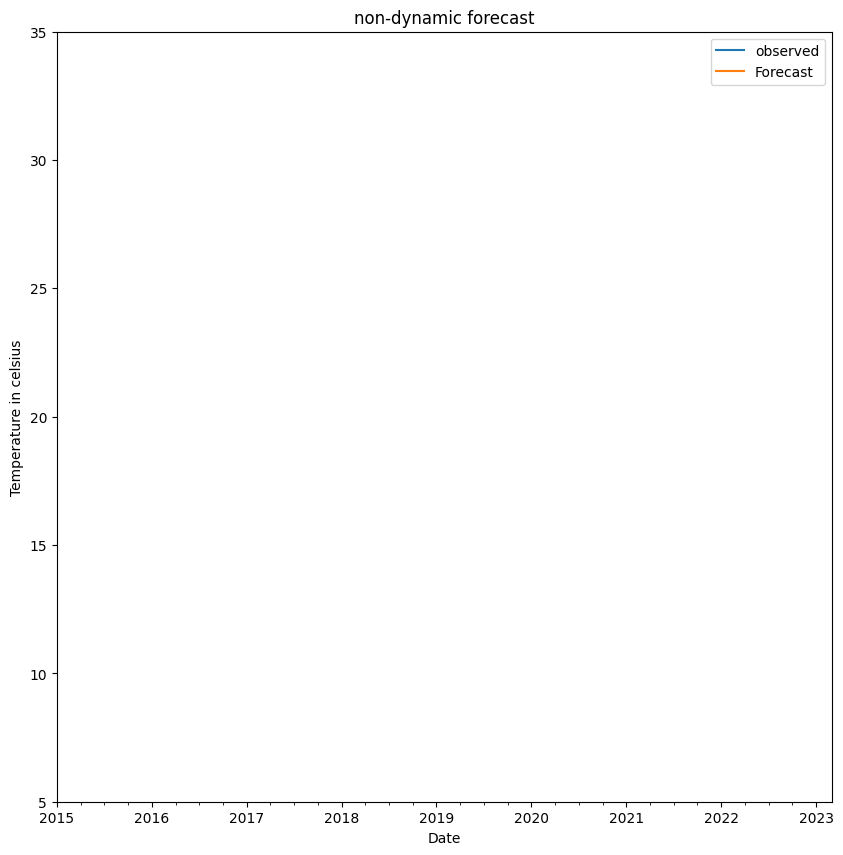

In [39]:
pred = results.get_prediction(start=pd.to_datetime('2017-5-1'), dynamic=False) ###change prediction year here
pred_ci = pred.conf_int()

ax = one_step_df.average_actual['2015':].plot(label='observed') ### chagne year limit here
pred.predicted_mean.plot(ax = ax, label='Forecast')

ax.fill_between(pred_ci.index,
               pred_ci.iloc[:,0],
               pred_ci.iloc[:,1], color='k', alpha = 0.2)

ax.set_xlabel('Date')
ax.set_ylabel('Temperature in celsius')
plt.ylim([5,35])
plt.legend()
plt.title('non-dynamic forecast')
plt.show()